### Data loading and preparation

* Load the libraries
* Download the data
* Look at the data
* Prepare target variable
* Fill missing values
* Make other necessary changes

#### Load the libraries

In [2]:
# general purpose
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mutual_info_score

#### Download the data

In [3]:
# load the data
file_url = 'https://archive.ics.uci.edu/static/public/222/data.csv'
df = pd.read_csv(file_url)

#### Look at the data

In [4]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN,no
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN,no
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN,no
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN,no


#### Prepare target variable

In [5]:
# convert target var to numerical
df.y = df.y.map({'yes':1,'no':0})

#### Fill missing value

In [6]:
df.columns[df.isna().any()]

Index(['job', 'education', 'contact', 'poutcome'], dtype='object')

All missing values are in string columns, so I'll use 'unknown' to replace NaNs

In [7]:
df.fillna('unknown', inplace=True)

#### Make other necessary changes

On the project website, the `duration` column is described as follows:

> last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

Accordingly, I'll drop the `duration` column

In [8]:
# drop duration
df.drop('duration', axis=1, inplace=True)

### EDA

* Look at the value ranges of the numerical features
* Look at the value ranges of the categorical features
* Feature importance analysis 
* Feature importance: Mutual information score
* Feature importance: Correlation
* Numerical features colinearity

In [9]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,1,-1,0,unknown,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,1,-1,0,unknown,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,1,-1,0,unknown,0


In [10]:
num = ['age', 'balance', 'day_of_week', 'campaign', 'pdays', 'previous']
cat = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
features = num + cat

#### Look at the value ranges of the numerical features

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,45211.0,40.936210,10.618762,18.0,33.0,39.0,48.0,95.0
balance,45211.0,1362.272058,3044.765829,-8019.0,72.0,448.0,1428.0,102127.0
day_of_week,45211.0,15.806419,8.322476,1.0,8.0,16.0,21.0,31.0
campaign,45211.0,2.763841,3.098021,1.0,1.0,2.0,3.0,63.0
pdays,45211.0,40.197828,100.128746,-1.0,-1.0,-1.0,-1.0,871.0
previous,45211.0,0.580323,2.303441,0.0,0.0,0.0,0.0,275.0
y,45211.0,0.116985,0.321406,0.0,0.0,0.0,0.0,1.0


array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'balance'}>],
       [<Axes: title={'center': 'day_of_week'}>,
        <Axes: title={'center': 'campaign'}>],
       [<Axes: title={'center': 'pdays'}>,
        <Axes: title={'center': 'previous'}>]], dtype=object)

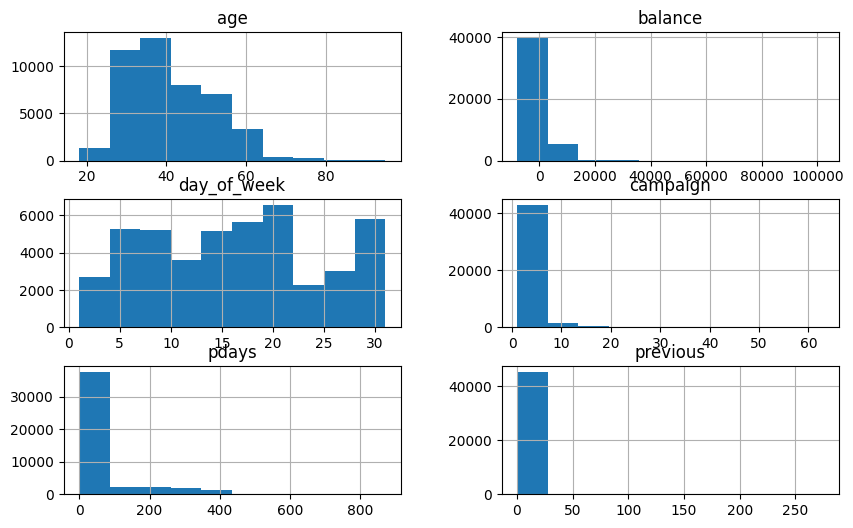

In [12]:
df[num].hist(figsize=(10,6))

Most numerical features are skewed, some have extreme outliers. 

#### Look at the value ranges of the categorical features

In [13]:
df[cat].nunique()

job          12
marital       3
education     4
default       2
housing       2
loan          2
contact       3
month        12
poutcome      4
dtype: int64

#### Feature importance analysis 

In [14]:
df.y.value_counts(normalize=True)

y
0    0.883015
1    0.116985
Name: proportion, dtype: float64

#### Feature importance analysis: Difference from mean and loan likelihood

In [15]:
from IPython.display import display

global_y = df.y.mean()

for c in cat:
    print(c)
    df_group = df.groupby(c).y.agg(['mean', 'count'])
    df_group['diff'] = df_group['mean'] - global_y
    df_group['likelihood'] = df_group['mean'] / global_y
    display(df_group)
    print()
    print()

job


,mean,count,diff,likelihood
job,,,,
admin.,0.122027,5171,0.005042,1.043099
blue-collar,0.072750,9732,-0.044235,0.621873
entrepreneur,0.082717,1487,-0.034268,0.707074
housemaid,0.087903,1240,-0.029082,0.751407
management,0.137556,9458,0.020571,1.175841
retired,0.227915,2264,0.110930,1.948246
self-employed,0.118429,1579,0.001445,1.012348
services,0.088830,4154,-0.028155,0.759330
student,0.286780,938,0.169796,2.451433




marital


,mean,count,diff,likelihood
marital,,,,
divorced,0.119455,5207,0.002470,1.021112
married,0.101235,27214,-0.015750,0.865366
single,0.149492,12790,0.032507,1.277874




education


,mean,count,diff,likelihood
education,,,,
primary,0.086265,6851,-0.030720,0.737402
secondary,0.105594,23202,-0.011390,0.902633
tertiary,0.150064,13301,0.033079,1.282764
unknown,0.135703,1857,0.018718,1.160003




default


,mean,count,diff,likelihood
default,,,,
no,0.117961,44396,0.000976,1.008345
yes,0.063804,815,-0.053181,0.545401




housing


,mean,count,diff,likelihood
housing,,,,
no,0.167024,20081,0.050039,1.427737
yes,0.077000,25130,-0.039985,0.658202




loan


,mean,count,diff,likelihood
loan,,,,
no,0.126557,37967,0.009572,1.081827
yes,0.066814,7244,-0.050171,0.571133




contact


,mean,count,diff,likelihood
contact,,,,
cellular,0.149189,29285,0.032204,1.275285
telephone,0.134205,2906,0.017220,1.147201
unknown,0.040707,13020,-0.076278,0.347965




month


,mean,count,diff,likelihood
month,,,,
apr,0.196794,2932,0.079809,1.682218
aug,0.110133,6247,-0.006852,0.941429
dec,0.467290,214,0.350305,3.994448
feb,0.166478,2649,0.049493,1.423073
jan,0.101212,1403,-0.015773,0.865170
jul,0.090935,6895,-0.026049,0.777327
jun,0.102228,5341,-0.014757,0.873857
mar,0.519916,477,0.402931,4.444305
may,0.067195,13766,-0.049790,0.574387




poutcome


,mean,count,diff,likelihood
poutcome,,,,
failure,0.126097,4901,0.009112,1.077890
other,0.166848,1840,0.049863,1.426235
success,0.647253,1511,0.530269,5.532800
unknown,0.091615,36959,-0.025370,0.783136


Some of the information displayed here will be useful in the feature engineering section

#### Feature importance: Mutual information score


In [16]:
mi = df[cat].apply(lambda col: mutual_info_score(col, df.y))
mi.sort_values(ascending=False)

poutcome     0.029397
month        0.024351
contact      0.013627
housing      0.009654
job          0.008264
loan         0.002630
education    0.002598
marital      0.002101
default      0.000294
dtype: float64

#### Feature importance: Correlation

In [17]:
df[num].corrwith(df.y).abs().sort_values(ascending=False)

pdays          0.103621
previous       0.093236
campaign       0.073172
balance        0.052838
day_of_week    0.028348
age            0.025155
dtype: float64

#### Numerical features colinearity

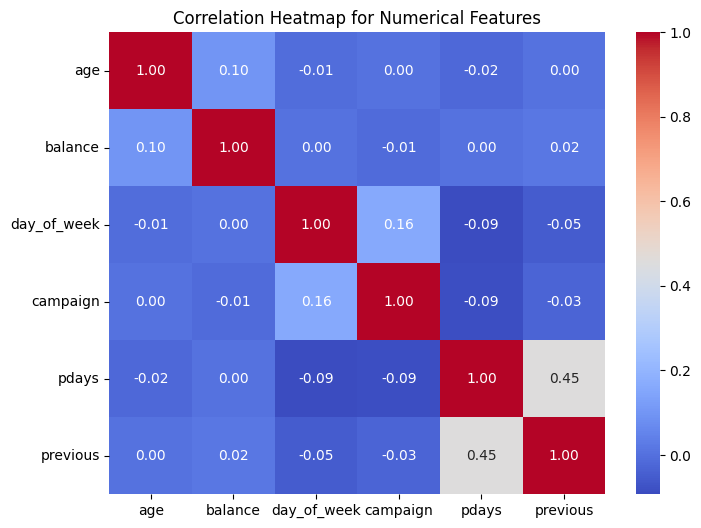

In [18]:
# Calculate the correlation matrix
corr_matrix = df[num].corr()

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={"size": 10})
plt.title('Correlation Heatmap for Numerical Features')
plt.show()